In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, StratifiedKFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import *

import tensorflow.keras as keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import math

import os
from PIL import Image

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Parâmetros

In [3]:
percentege_test_size = 0.2
undersampling_size = -1 # -1 para não fazer undersampling

BATCH_SIZE = 16

# fig preprocessing
# largura = 150
# altura = 150
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

diretorio = './PokemonData/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
# diretorio = '../dados classificacao imagens/pneumonia/'
# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '/home/carlos/Downloads/dados-docs/'
# diretorio = '../dados classificacao imagens/gatos-patos-caes-rapozas-coelhos/treino/'

## Carregando Dataset

In [4]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img) and (not '.svg' in img):
            dados.append([diretorio+classe+'/'+img,classe])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados

,image,target
0,./PokemonData/Drowzee/b8b6717a6a754bc9968b319b...,Drowzee
1,./PokemonData/Geodude/ce02029b798145699d40a0d1...,Geodude
2,./PokemonData/Kakuna/4e4cf47388b24a1f904063350...,Kakuna
3,./PokemonData/Farfetchd/fd3d3c4d98ce44349d6472...,Farfetchd
4,./PokemonData/Vulpix/878d933dbaf54ab5b102f7af9...,Vulpix
...,...,...
6820,./PokemonData/Victreebel/abb3b4052943485b91ff1...,Victreebel
6821,./PokemonData/Spearow/9fe6308dbb6449ae99783d22...,Spearow
6822,./PokemonData/Spearow/a335dd612d2548adaaa83201...,Spearow
6823,./PokemonData/Gyarados/072966eb45f1456a8c3fbdd...,Gyarados


## Analisando Dados

In [5]:
print(f'Quantidade de classes totais: {df_dados["target"].nunique()}')
print(f'Quantidade de imagens totais: {df_dados["target"].count()}')
print(f'Média de imagens por classe: {df_dados["target"].value_counts().mean()}')
print(f'Menor quantidade de imagens em uma classe: {df_dados["target"].value_counts().min()}')
print(f'Maior quantidade de imagens em uma classe: {df_dados["target"].value_counts().max()}')

Quantidade de classes totais: 150
Quantidade de imagens totais: 6825
Média de imagens por classe: 45.5
Menor quantidade de imagens em uma classe: 26
Maior quantidade de imagens em uma classe: 66


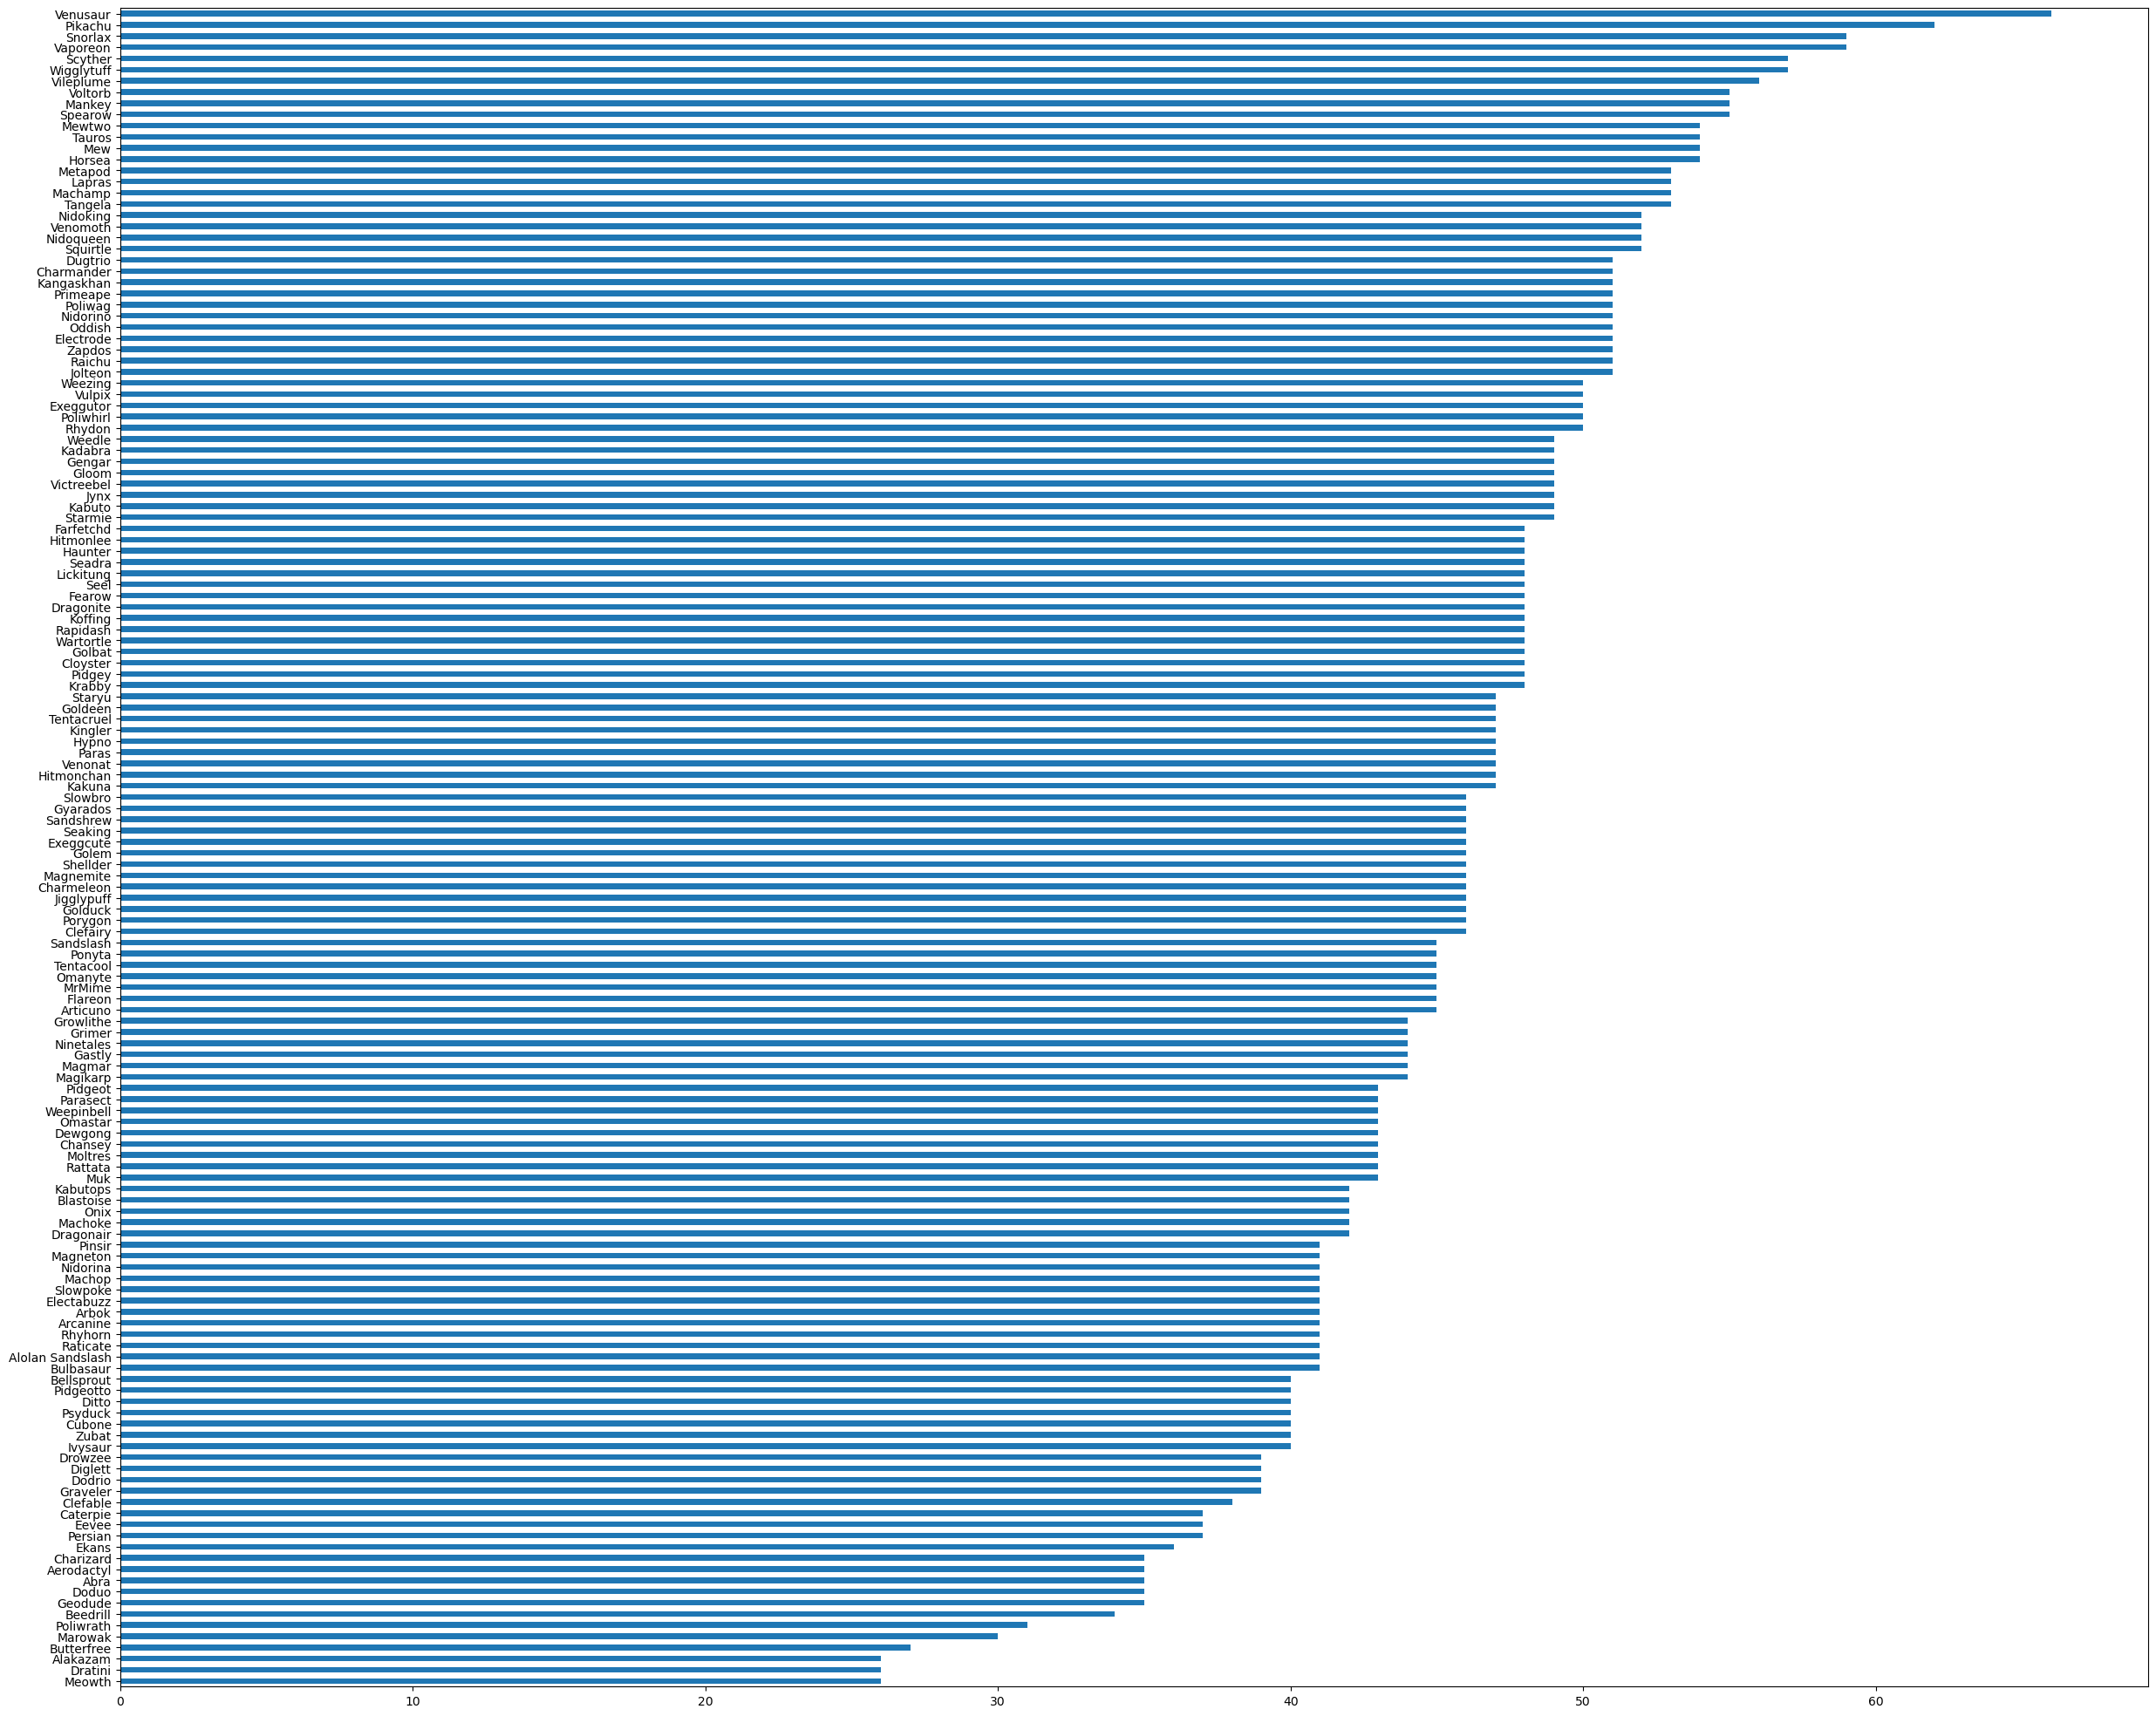

In [6]:
plt.figure(figsize=(30,25))
df_dados['target'].value_counts(ascending=True).plot(kind='barh')

plt.show()

In [7]:
heights = []
widths = []

# iterar através das imagens no diretório
for filename in df_dados['image']:
    # abrir imagem
    img = Image.open(filename)
    # obter dimensões
    width, height = img.size
    # adicionar dimensões à lista
    widths.append(width)
    heights.append(height)

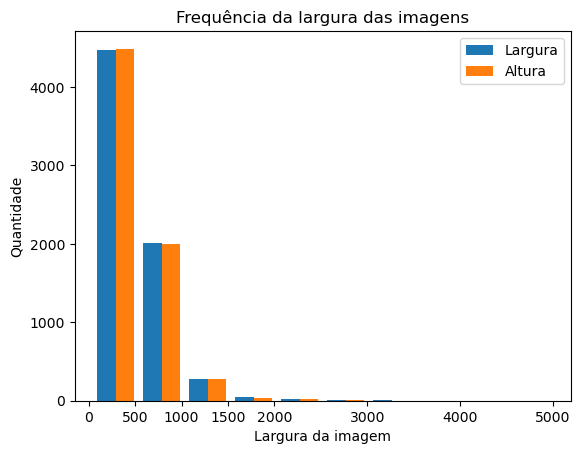

In [8]:
plt.hist([widths, heights])

plt.title("Frequência da largura das imagens")

plt.xlabel("Largura da imagem")
plt.ylabel("Quantidade")

plt.legend(["Largura", "Altura"])

plt.xticks([0, 500, 1000, 1500, 2000, 3000, 4000, 5000])

plt.show()

In [9]:
# calcular tamanho médio
mean_width = sum(w for w in widths) / len(widths)
mean_height = sum(h for h in heights) / len(heights)

print(f"Tamanho médio das imagens em relação a \nwidth: {mean_width} \nheight: {mean_height}")

Tamanho médio das imagens em relação a 
width: 470.407032967033 
height: 466.21758241758243


In [10]:
sorted_widths = sorted(widths)
sorted_heights = sorted(heights)

num_images = len(widths)

if num_images % 2 == 0:
    median_width = (sorted_widths[num_images//2 - 1] + sorted_widths[num_images//2]) / 2
    median_height = (sorted_heights[num_images//2 - 1] + sorted_heights[num_images//2]) / 2
else:
    median_width = sorted_widths[num_images//2]
    median_height = sorted_heights[num_images//2]
    
print(f"Mediana das imagens em relação a \nwidth: {median_width} \nheight: {median_height}")

Mediana das imagens em relação a 
width: 354 
height: 353


In [11]:
percentil35_width = np.percentile(widths, 35)
percentil35_height = np.percentile(heights, 35)

print(f"Percentil 35 em relação a \nwidth: {percentil35_width} \nheight: {percentil35_height}")

Percentil 35 em relação a 
width: 256.0 
height: 256.0


In [12]:
print(f"Tamanho da menor imagem em relação a \nwidth: {min(widths)} \nheight: {min(heights)}")

Tamanho da menor imagem em relação a 
width: 43 
height: 42


In [13]:
print(f"Tamanho da maior imagem em relação a \nwidth: {max(widths)} \nheight: {max(heights)}")

Tamanho da maior imagem em relação a 
width: 5000 
height: 4356


In [14]:
# largura = math.floor(mean_width)
# altura = math.floor(mean_height)
largura = int(min(percentil35_width, percentil35_height))
altura = int(min(percentil35_width, percentil35_height))

print(f"Largura e altura escolhidas, respectivamente: {largura}, {altura}")

Largura e altura escolhidas, respectivamente: 256, 256


In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Preparando Dados

In [ ]:
def getEmbedder():
    # return EfficientNetB0(weights='imagenet', include_top=False)
    # return EfficientNetB2(weights='imagenet', include_top=False)
    # return EfficientNetB3(weights='imagenet', include_top=False)
    # return EfficientNetB4(weights='imagenet', include_top=False)
    # return EfficientNetB7(weights='imagenet', include_top=False)
    return InceptionV3(weights='imagenet', include_top=False)
    # return Xception(weights='imagenet', include_top=False)
    # return DenseNet201(weights='imagenet', include_top=False)
    # return MobileNetV3Small(weights='imagenet', include_top=False)
    # return VGG19(weights='imagenet', include_top=False)
    # return InceptionResNetV2(weights='imagenet', include_top=False)

def embedding(embedder, img_path, largura, altura, modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    embed = np.expand_dims(embed, axis=0)
        # embed = preprocess_input(embed)

    features = embedder.predict(embed)

    return features[0][0][0]

def embeddingTest(embedder, img_path, largura, altura, modo_de_cor, n_transformations):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    
    array_img_transformed = []
    
    # FAZER NA IMAGEM ORINAL SEM MUDAR NADA
    img_transformed = image.img_to_array(img)

    embed = np.expand_dims(img_transformed, axis=0)
    # embed = preprocess_input(embed)

    features = embedder.predict(embed)
    
    array_img_transformed.append(features[0][0][0])
        
    for _ in range(n_transformations):
        
        img_transformed = data_images_generator.random_transform(image.img_to_array(img))

        embed = np.expand_dims(img_transformed, axis=0)
            # embed = preprocess_input(embed)

        features = embedder.predict(embed)
        
        array_img_transformed.append(features[0][0][0])

    return np.array(array_img_transformed)

def embeddingWithoutModel(img_path, largura, altura, modo_de_cor):
    
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)
    
    shape_entrada = largura*altura*1

    if(modo_de_cor == 'rgb'):
        shape_entrada = largura*altura*3

    if(modo_de_cor == 'rgba'):
        shape_entrada = largura*altura*4
    
    return embed.reshape(shape_entrada)

embedder = getEmbedder()

In [ ]:
#tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

In [ ]:
target = df_dados['target'].array
n_transformations = 0

array_features = []
for x in dados:
    # array_features.append(embedding(embedder, x[0], largura, altura, modo_de_cor))
    array_features.extend(embeddingTest(embedder, x[0], largura, altura, modo_de_cor, n_transformations))
    # array_features.append(embeddingWithoutModel(x[0], largura, altura, modo_de_cor))

scaler = preprocessing.StandardScaler()

# array_features = np.array(array_features, dtype=np.uint8)

array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)

df_features

In [19]:
target_transformation = np.repeat(target, n_transformations + 1) # imagens transformadas + a original

target_transformation

<PandasArray>
[          'Fearow',           'Seadra',        'Magnemite',
         'Cloyster',         'Alakazam',         'Articuno',
         'Articuno',           'Horsea',         'Nidoking',
          'Starmie',
 ...
         'Venomoth',        'Exeggcute',        'Vileplume',
 'Alolan Sandslash',       'Weepinbell',       'Electabuzz',
          'Kingler',        'Wartortle',          'Tangela',
          'Kadabra']
Length: 6825, dtype: object

## Reduzindo a Dimensionalidade

In [20]:
model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50)
array_red = model.fit_transform(df_features) 

df_tsne = pd.DataFrame(array_red)

df_tsne['target'] = target_transformation

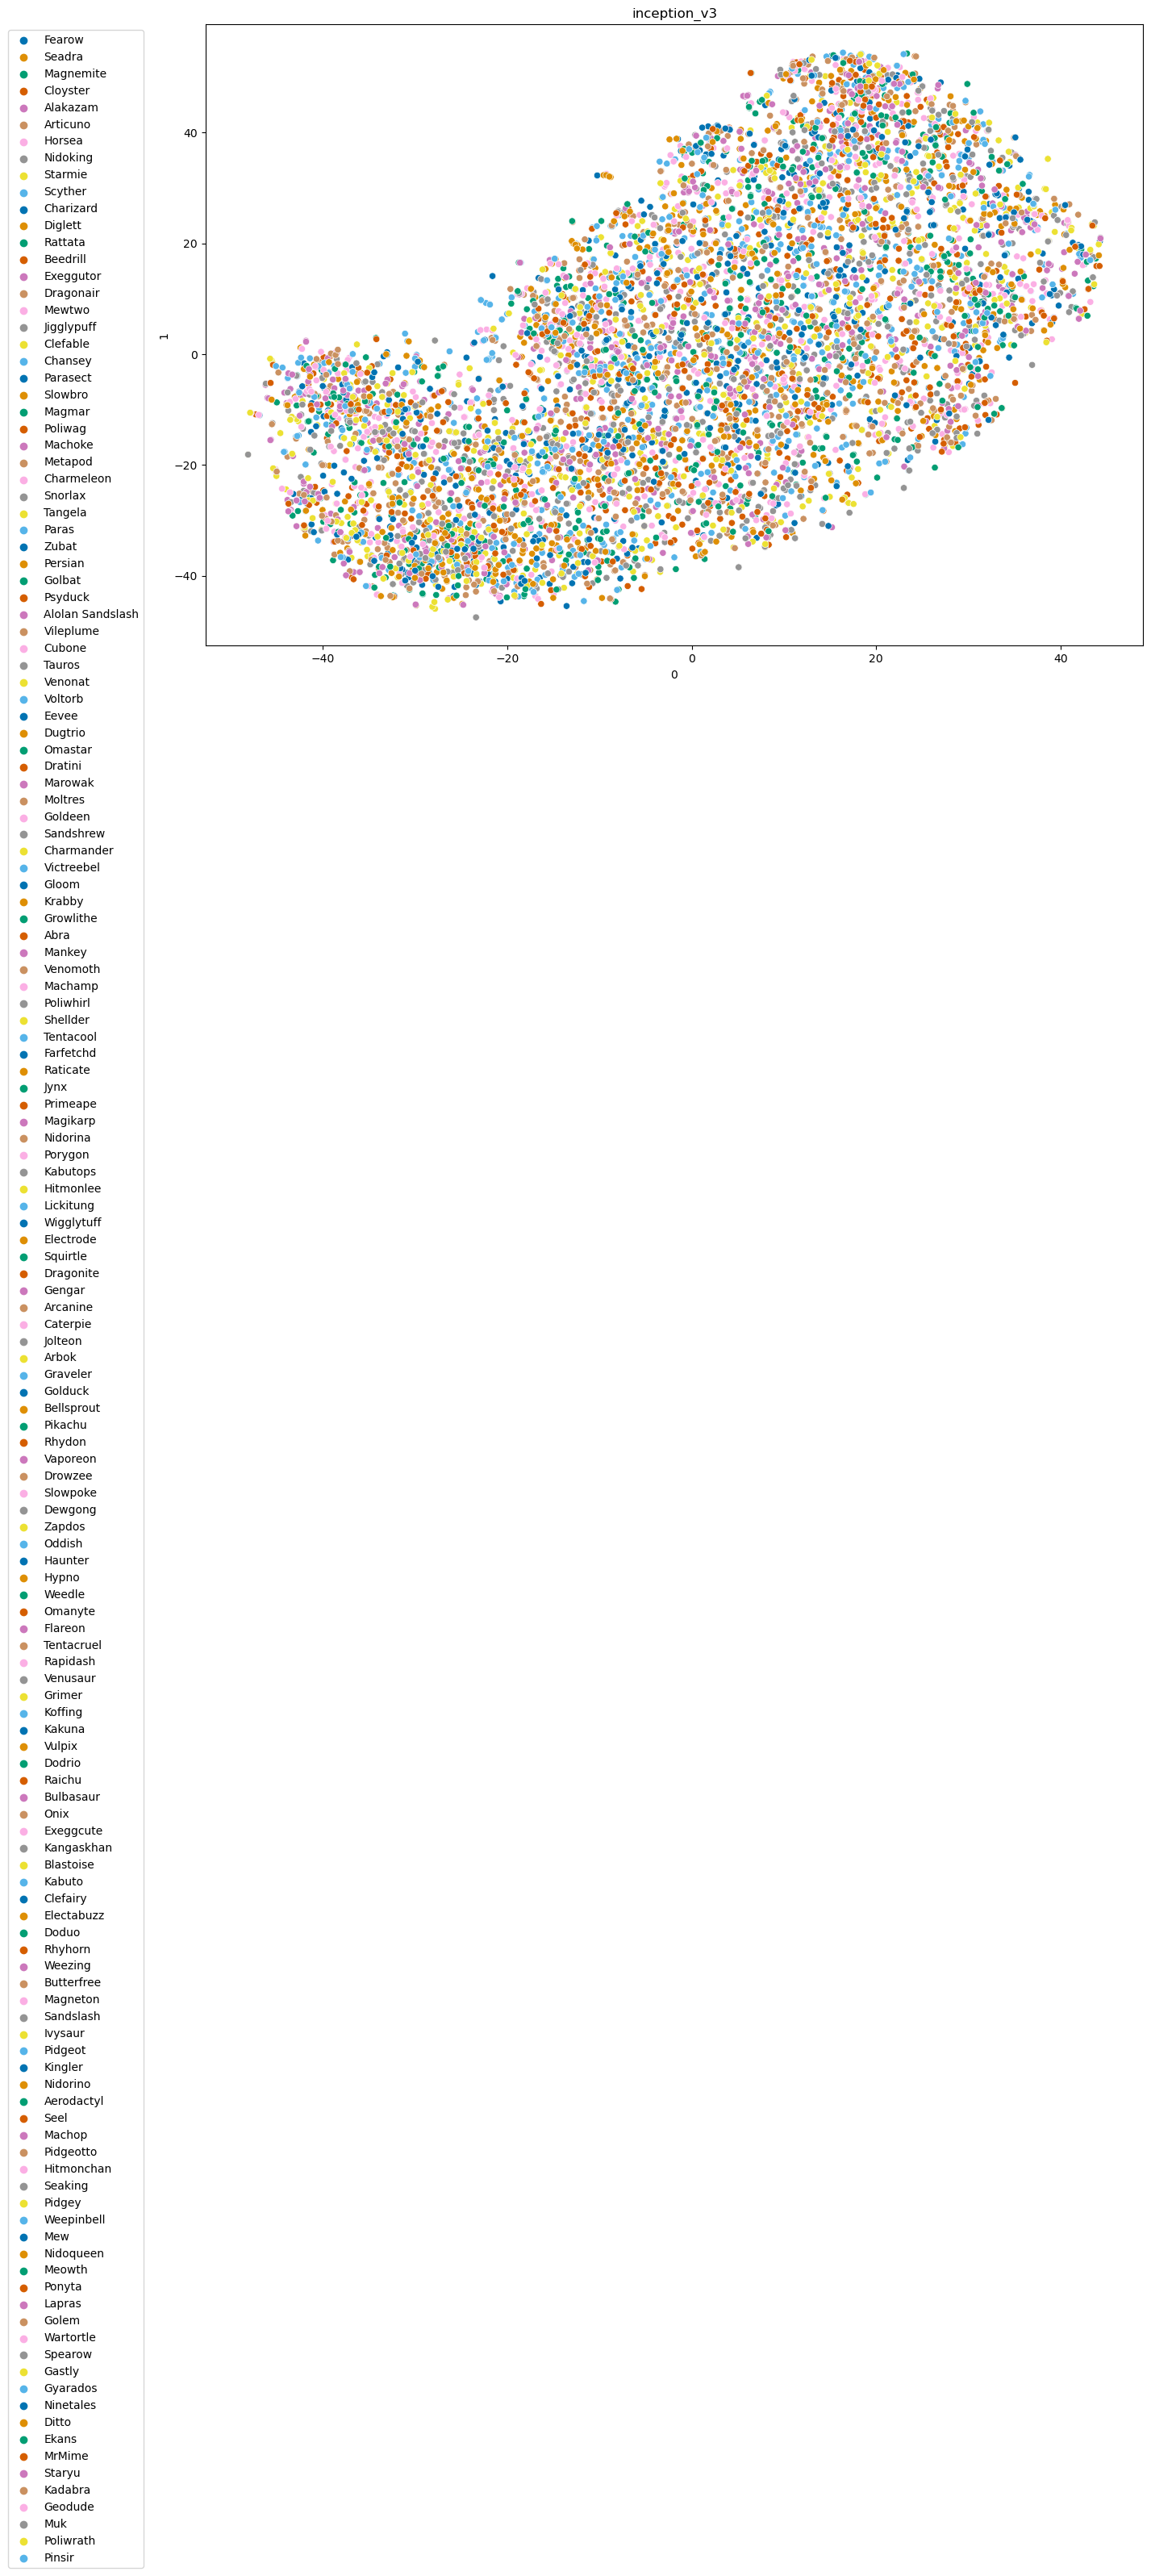

In [21]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne, x=df_tsne[0], y=df_tsne[1], hue=df_tsne['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name}", bbox_inches="tight")

plt.show()

## Mostrando só algumas classes da redução de dimensionalidade

In [22]:
ten_classes = df_tsne['target'].unique()[0:10]

ten_classes

array(['Fearow', 'Seadra', 'Magnemite', 'Cloyster', 'Alakazam',
       'Articuno', 'Horsea', 'Nidoking', 'Starmie', 'Scyther'],
      dtype=object)

In [23]:
df_tsne_filter_by_ten_classes = df_tsne[df_tsne['target'].isin(ten_classes)]

df_tsne_filter_by_ten_classes.head()

,0,1,target
0,-10.577888,-29.514412,Fearow
1,2.152351,29.968111,Seadra
2,-21.847961,-38.151939,Magnemite
3,-12.947043,-32.975471,Cloyster
4,36.313740,24.871660,Alakazam


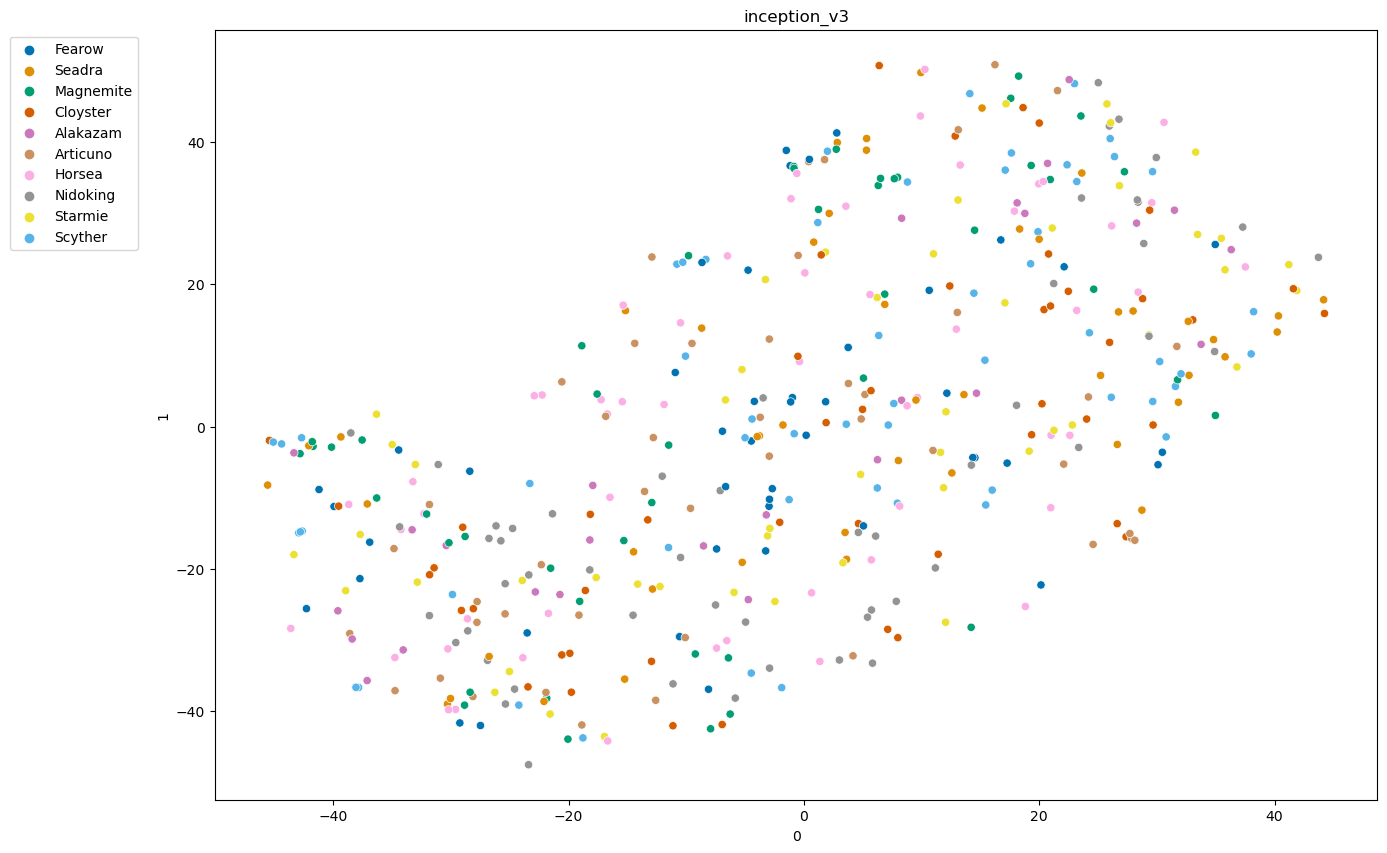

In [24]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.scatterplot(data=df_tsne_filter_by_ten_classes, x=df_tsne_filter_by_ten_classes[0], y=df_tsne_filter_by_ten_classes[1], hue=df_tsne_filter_by_ten_classes['target'], palette="colorblind")

plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title(getEmbedder().name)

plt.savefig(f"Embedding {getEmbedder().name} - Filtered by 10 Classes", bbox_inches="tight")

plt.show()

## Usando deep learning com transferlearning

In [16]:
data_images_generator_train = ImageDataGenerator(rescale=1./255, # rescalar
                                            rotation_range=40, # rotacionar imagem
                                            width_shift_range=0.2, # deslocamento horizontal
                                            height_shift_range=0.2, # deslocamento vertical
                                            shear_range=0.2, # cisalhamento
                                            zoom_range=0.2, # zoom
                                            horizontal_flip=True, # inverter horizontalmente
                                            fill_mode='nearest')

data_images_generator_test = ImageDataGenerator(rescale=1./255)

In [17]:
x_train_balanced, x_val_balanced, y_train_balanced, y_val_balanced = train_test_split(df_dados['image'], df_dados['target'], test_size=0.30, stratify=df_dados['target'])

x_val_balanced, x_test_balanced, y_val_balanced, y_test_balanced = train_test_split(x_val_balanced, y_val_balanced, test_size=0.50, stratify=y_val_balanced)

In [18]:
len(x_train_balanced), len(x_val_balanced), len(x_test_balanced)

(4777, 1024, 1024)

In [19]:
len(y_train_balanced), len(y_val_balanced), len(y_test_balanced)

(4777, 1024, 1024)

In [20]:
print(f'{len(x_train_balanced)} + {len(x_val_balanced)} = {len(x_train_balanced) + len(x_val_balanced)}')

4777 + 1024 = 5801


In [21]:
print(f'{len(y_train_balanced)} + {len(y_val_balanced)} = {len(y_train_balanced) + len(y_val_balanced)}')

4777 + 1024 = 5801


In [22]:
df_dados_train = pd.DataFrame({'image': x_train_balanced, 'target': y_train_balanced})

df_dados_train

,image,target
3925,./PokemonData/Magikarp/e7ca0ab0afc24c2cb099ea4...,Magikarp
5326,./PokemonData/Cloyster/c244e2ad80214d1180cd4a0...,Cloyster
4582,./PokemonData/Pinsir/ddd60723444044c9b392140d7...,Pinsir
216,./PokemonData/Raichu/89abc326119145fb942976aae...,Raichu
6169,./PokemonData/Persian/9d57816712e342619589f268...,Persian
...,...,...
3146,./PokemonData/Clefable/12ad62d64bbd48c7ac4b7a3...,Clefable
2978,./PokemonData/Aerodactyl/263b3cb088e5448e99335...,Aerodactyl
5766,./PokemonData/Mewtwo/00000045.png,Mewtwo
4446,./PokemonData/Gengar/28b8902333724f6d89abc745a...,Gengar


In [23]:
df_dados_val = pd.DataFrame({'image': x_val_balanced, 'target': y_val_balanced})

df_dados_val

,image,target
5724,./PokemonData/Weepinbell/faa43ab8d3574dea99e82...,Weepinbell
319,./PokemonData/Ninetales/c91af409d7594d6892bf7d...,Ninetales
755,./PokemonData/Squirtle/1debff5538d7402188a3808...,Squirtle
6291,./PokemonData/Rhydon/c85a1145f25d44ccbf530849f...,Rhydon
3812,./PokemonData/Haunter/626d9a341c74475abae6f902...,Haunter
...,...,...
4830,./PokemonData/Vulpix/954632b91fc8489f85b308efa...,Vulpix
3727,./PokemonData/Mew/41b73ada3af24cb68ab42e677e91...,Mew
896,./PokemonData/Jolteon/d7e651b8adcb4154b9c1ea0f...,Jolteon
6812,./PokemonData/Tangela/9c736998ddbd4407a88f72d1...,Tangela


In [24]:
data_gen_train = data_images_generator_train.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_train,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=True,
                                                     target_size=(largura,altura))

data_gen_val= data_images_generator_test.flow_from_dataframe(batch_size=BATCH_SIZE,
                                                     dataframe=df_dados_val,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=False,
                                                     target_size=(largura,altura))


Found 4775 validated image filenames belonging to 150 classes.
Found 1022 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


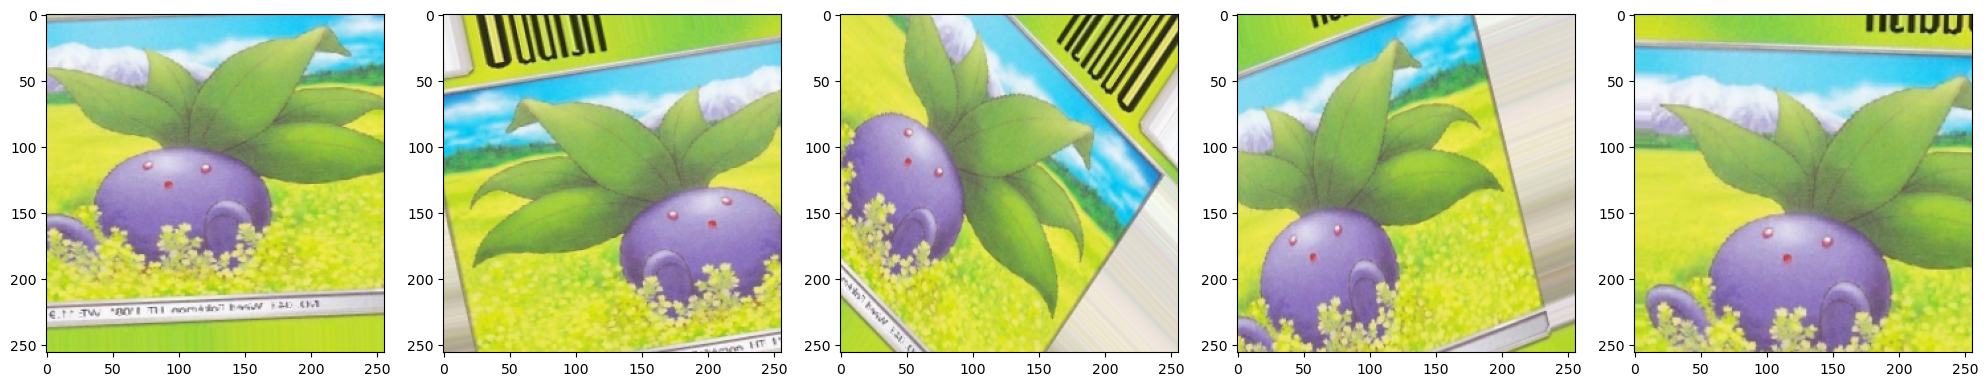

In [25]:
images = [data_gen_train[0][0][8] for i in range(5)]
plotImages(images)

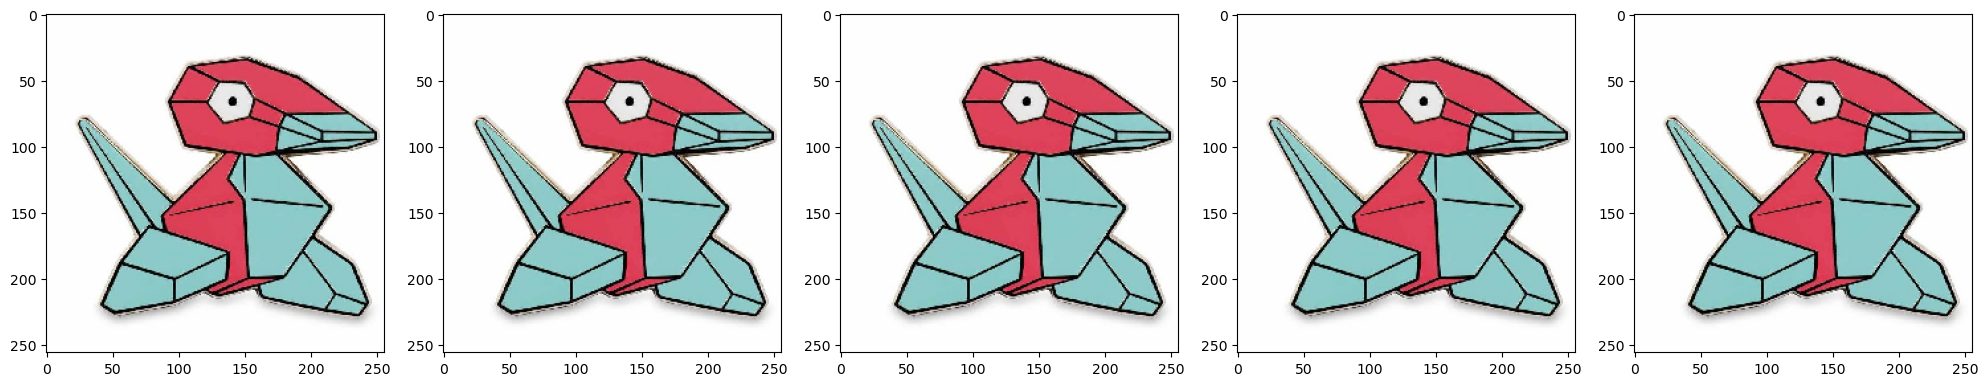

In [26]:
images = [data_gen_val[0][0][8] for i in range(5)]
plotImages(images)

In [27]:
conv_base = keras.applications.DenseNet201(weights='imagenet', include_top=False,#.Xception(weights='imagenet', include_top=False,
                  input_shape=(largura,altura,3))
conv_base.trainable = False

In [28]:
my_init = keras.initializers.glorot_uniform(seed = 1)
model = keras.models.Sequential([
    conv_base,
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    
    keras.layers.Dropout(0.15),

    keras.layers.Dense(1024, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.15),
    
    keras.layers.Dense(512, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(150, activation='softmax', kernel_initializer = my_init)
                         
])

In [28]:
my_init = keras.initializers.glorot_uniform(seed = 1)
model = keras.models.Sequential([
    conv_base,
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),

    keras.layers.Dense(512, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.15),
    
    keras.layers.Dense(128, activation='relu', kernel_initializer = my_init, kernel_regularizer=regularizers.l2(0.001)), # regularizer - evitar overfitting
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(150, activation='softmax', kernel_initializer = my_init)
                         
])

In [29]:
import keras.backend as K

def f1_score_k(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision_aux = true_positives / (predicted_positives + K.epsilon())
    recall_aux = true_positives / (possible_positives + K.epsilon())
    
    f1 = 2 * (precision_aux * recall_aux) / (precision_aux + recall_aux + K.epsilon())
    return f1

In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(), f1_score_k])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 1920)       7680      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

In [32]:
EPOCHS = 40

In [33]:
callbacks = [
    ModelCheckpoint("PokemonClassification.h5", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=5), ## interrompe se nao houver melhora apos um numero de epocas definidas
    ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=3) ## nao melhora apos um numero de epocas definidas
]

In [34]:
len(data_gen_train) * 16

4784

In [35]:
history = model.fit(
            data_gen_train,
            #steps_per_epoch=math.ceil(len(data_gen_train) / BATCH_SIZE),
            epochs=EPOCHS,
            validation_data=data_gen_val,
           # validation_steps=math.ceil(len(data_gen_test) / BATCH_SIZE),
            callbacks=callbacks
          )

Epoch 1/40
299/299 [==============================] - 143s 416ms/step - loss: 4.4147 - accuracy: 0.2513 - precision: 0.9144 - recall: 0.0358 - auc: 0.8374 - f1_score_k: 0.0639 - val_loss: 2.7656 - val_accuracy: 0.5832 - val_precision: 0.9312 - val_recall: 0.1986 - val_auc: 0.9761 - val_f1_score_k: 0.3170 - lr: 0.0010
Epoch 2/40
299/299 [==============================] - 106s 355ms/step - loss: 2.5042 - accuracy: 0.6088 - precision: 0.9414 - recall: 0.2555 - auc: 0.9807 - f1_score_k: 0.3887 - val_loss: 1.8278 - val_accuracy: 0.7309 - val_precision: 0.9294 - val_recall: 0.5284 - val_auc: 0.9893 - val_f1_score_k: 0.6652 - lr: 0.0010
Epoch 3/40
299/299 [==============================] - 106s 354ms/step - loss: 1.8830 - accuracy: 0.7257 - precision: 0.9305 - recall: 0.4932 - auc: 0.9901 - f1_score_k: 0.6360 - val_loss: 1.6090 - val_accuracy: 0.7613 - val_precision: 0.8993 - val_recall: 0.6380 - val_auc: 0.9932 - val_f1_score_k: 0.7419 - lr: 0.0010
Epoch 4/40
299/299 [=======================

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

In [37]:
epochs_range = range(39) # range(EPOCHS)

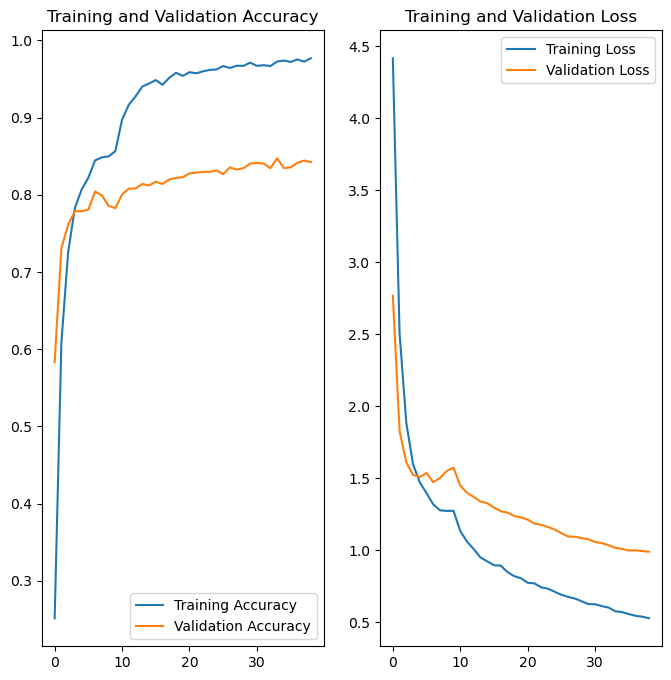

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

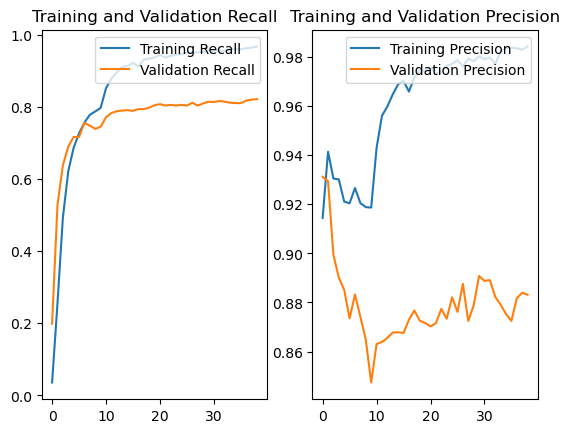

In [39]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')

plt.show()

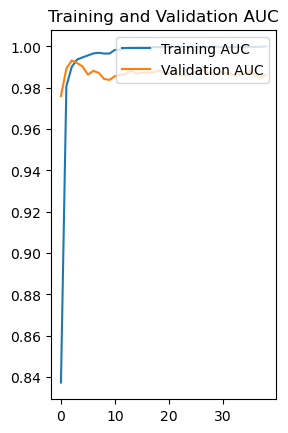

In [40]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC')

plt.show()

## Avaliação nos dados de teste

In [41]:
df_dados_test = pd.DataFrame({'image': x_test_balanced, 'target': y_test_balanced})

df_dados_test

,image,target
3973,./PokemonData/Vaporeon/a092574ddfd6461ea14f98a...,Vaporeon
4463,./PokemonData/Charmeleon/90a1137448f44acfbd1c8...,Charmeleon
5357,./PokemonData/Grimer/d589131188414a1096809abb4...,Grimer
6175,./PokemonData/Fearow/a212bb3a0d0e413eb56b9e3e0...,Fearow
1577,./PokemonData/Ninetales/0e22faaa8ffb42b6a7e13a...,Ninetales
...,...,...
819,./PokemonData/Slowpoke/e7a843f1601c40eaa12ea5d...,Slowpoke
1397,./PokemonData/Grimer/bf581a0372a342dd8a3bc92e2...,Grimer
2161,./PokemonData/Gloom/15f57b6424b24656ab0f11b89d...,Gloom
979,./PokemonData/Starmie/869dcaa4930941fc808ccf24...,Starmie


In [42]:
data_gen_test = data_images_generator_test.flow_from_dataframe(batch_size=1,
                                                     dataframe=df_dados_test,
                                                     x_col='image',
                                                     y_col='target',
                                                     shuffle=False,
                                                     target_size=(largura,altura))

Found 1023 validated image filenames belonging to 150 classes.


C:\Users\wende\anaconda3\envs\data-science\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [43]:
def embeddingImageTest(img_path,largura,altura,modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)

    return embed

y_full_test = preprocessing.LabelEncoder().fit_transform(df_dados_test['target'])
X_full_test  = []
for x in df_dados_test['image']:
    X_full_test.append(embeddingImageTest(x,largura,altura,modo_de_cor))

X_full_test = np.array(X_full_test)/255.0

In [44]:
model.evaluate(data_gen_test)

1023/1023 [==============================] - 63s 59ms/step - loss: 0.9633 - accuracy: 0.8602 - precision: 0.9001 - recall: 0.8368 - auc: 0.9891 - f1_score_k: 0.8368


[0.9632969498634338,
 0.8602150678634644,
 0.9001051783561707,
 0.8367546200752258,
 0.9890843629837036,
 0.836754560470581]